# Cats vs Dogs - Transfer Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
# turn off GPU if needed

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [24]:
import tensorflow as tf

from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling, Input, Lambda
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
print("TensorFlow version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.12.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preparing filepaths

In [5]:
# set up the folder structure

folder = 'data/dogs-vs-cats/'
train_folder = folder + 'train/'
test_folder = folder + 'test/'

# glob to get the file paths
train_paths = glob.glob(train_folder + '*')
test_paths = glob.glob(test_folder + '*')

In [6]:
# check the file paths

train_paths[0], test_paths[0]

('data/dogs-vs-cats/train/dog.8011.jpg', 'data/dogs-vs-cats/test/9733.jpg')

# Defining variables

In [7]:
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Create test Dataset (no labels)

In [8]:
# load the test dataset, no label extraction needed

def process_test_path(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  return img

In [9]:
# build the test dataset

test_paths = tf.data.Dataset.list_files(test_paths, shuffle=False)

test_ds = test_paths.map(process_test_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds

Metal device set to: Apple M3

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



<_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [10]:
# check the test dataset

for images in test_ds.take(1):
  print(images.shape)

(32, 224, 224, 3)


2025-04-20 10:09:52.154049: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Extracting train labels from filepath

In [11]:
# get the class label from the filename

image_name = tf.strings.split(train_paths[0], sep='/')
label_tf = tf.strings.split(image_name[-1], sep='.')[0]
label_decoded = label_tf.numpy().decode()
label_decoded


'dog'

In [12]:
# create a dictionary to track the class names

class_names = {0: 'cat', 1: 'dog'}
class_names

{0: 'cat', 1: 'dog'}

In [13]:
# create the a tf function to get the class label from the filename

def get_label(file_path):
  filename = tf.strings.split(file_path, '/')[-1]
  label_str = tf.strings.split(filename, sep='.')[0]

  # map label to integer
  label = tf.where(tf.equal(label_str, 'dog'), 1, 0)
  return label


In [14]:
# create a function to decode the actual images into tensors

def decode_img(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  return img

In [15]:
# create function to use the above 2 functions to return image and label pairs

def process_path(file_path):
  label = get_label(file_path)
  image = decode_img(file_path)
  return image, label

# Train/Val Split

In [16]:
# split train and val manually

# shuffle the list
train_paths = tf.random.shuffle(train_paths)

# split 80% train / 20% val
split_idx = int(0.8 * len(train_paths))

train_paths_split = train_paths[:split_idx]
val_paths_split = train_paths[split_idx:]

In [17]:
# create tensorflow datasets

train_ds = tf.data.Dataset.from_tensor_slices(train_paths_split)
val_ds = tf.data.Dataset.from_tensor_slices(val_paths_split)

In [18]:
# for each file path, load and process the image and label
# automatically optimize how many processes it uses to load and process files in parallel

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
# check the train dataset

for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.numpy())

(224, 224, 3)
0


In [20]:
# check the val dataset

for images, labels in val_ds.take(1):
  print(images.shape)
  print(labels.numpy())

(224, 224, 3)
0


# Optimizing the Dataset

In [21]:
# optimize the datasets

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# check train & val

train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Modeling

In [23]:
# load the pre-trained model

import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

pretrained = keras.applications.ResNet50V2(include_top=False,
                                            weights="imagenet",
                                            input_shape=INPUT_SHAPE
                                            )

# freeze the base model

pretrained.trainable = False

# create the preprocessing function

preprocessing = preprocess_input

94668760/94668760 [==============================] - 149s 2us/step


### Model #1 - Base Model

In [25]:
# define the transfer model

def build_cnn():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(Lambda(preprocessing))
  model.add(pretrained)
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [26]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2)                 200706    
                                                                 
Total params: 23,765,506
Trainable params: 200,706
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=5,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
625/625 [==============================] - 152s 240ms/step - loss: 0.8366 - accuracy: 0.9779 - val_loss: 1.2952 - val_accuracy: 0.9762
Epoch 2/5
625/625 [==============================] - 154s 246ms/step - loss: 0.3570 - accuracy: 0.9918 - val_loss: 1.3542 - val_accuracy: 0.9814
Epoch 3/5
625/625 [==============================] - 159s 254ms/step - loss: 0.1296 - accuracy: 0.9962 - val_loss: 1.1451 - val_accuracy: 0.9854
Epoch 4/5
625/625 [==============================] - 161s 258ms/step - loss: 0.1117 - accuracy: 0.9970 - val_loss: 1.6484 - val_accuracy: 0.9854
Epoch 5/5
625/625 [==============================] - 164s 262ms/step - loss: 0.1009 - accuracy: 0.9973 - val_loss: 2.5601 - val_accuracy: 0.9806


# Evaluate the Model

In [28]:
# define a function to plot history

def plot_history(history):
  for metric in history.history.keys():
    if not metric.startswith('val'):        # if it doesn't start with val
      plt.plot(history.history[metric], label=metric)
      if f'val_{metric}' in history.history.keys():     # if val is in the keys, then plot that as well
        plt.plot(history.history[f'val_{metric}'], label=f'val+{metric}')
      plt.title(metric)
      plt.legend()
      plt.show()

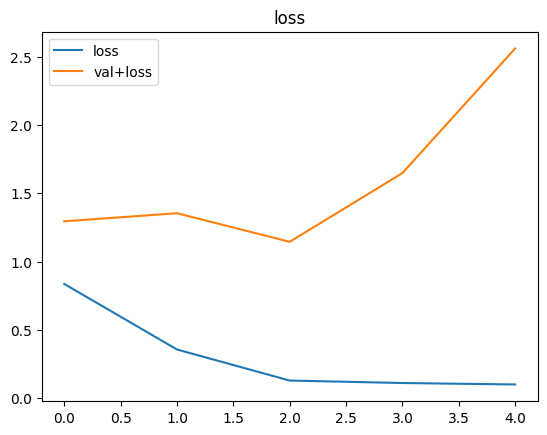

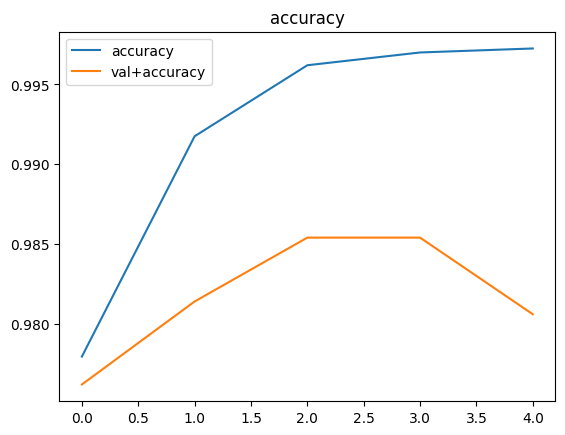

In [29]:
# plot the metrics

plot_history(history)

- the model improved for the first few epochs, but then quickly became overfit
- to address the issue of overfitting, I will add dropout layers

# Improve the transfer model

### Model #2

In [30]:
# define the transfer model

def build_cnn():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(Lambda(preprocessing))
  model.add(pretrained)
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [31]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 32)                3211296   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 26,776,162
Trainable params: 3,211,362
N

In [32]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=5,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
625/625 [==============================] - 154s 244ms/step - loss: 0.2093 - accuracy: 0.9737 - val_loss: 0.1211 - val_accuracy: 0.9580
Epoch 2/5
625/625 [==============================] - 168s 269ms/step - loss: 0.0443 - accuracy: 0.9865 - val_loss: 0.0478 - val_accuracy: 0.9848
Epoch 3/5
625/625 [==============================] - 170s 272ms/step - loss: 0.0284 - accuracy: 0.9919 - val_loss: 0.0592 - val_accuracy: 0.9850
Epoch 4/5
625/625 [==============================] - 172s 275ms/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.0609 - val_accuracy: 0.9860
Epoch 5/5
625/625 [==============================] - 175s 279ms/step - loss: 0.0122 - accuracy: 0.9954 - val_loss: 0.0689 - val_accuracy: 0.9850


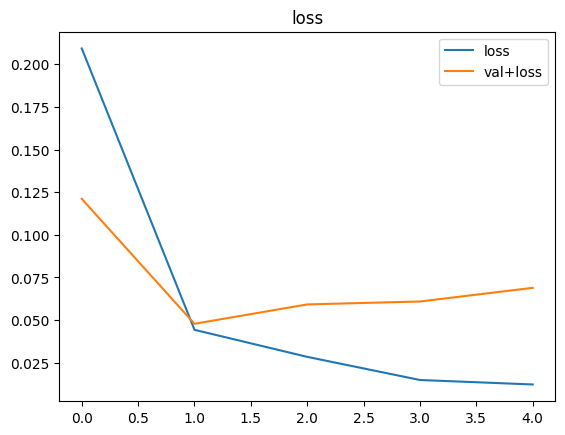

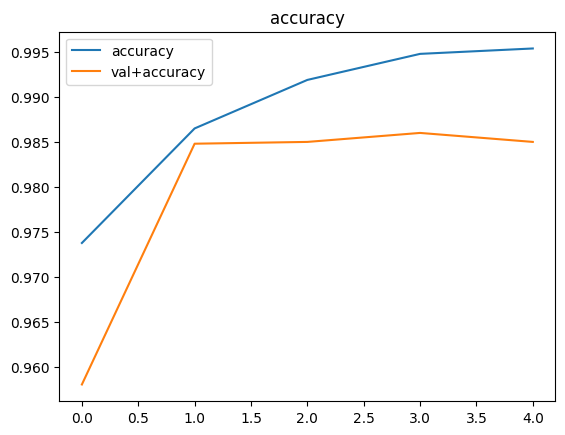

In [33]:
# plot the metrics

plot_history(history)

- the overfitting has definitely improved, but val does not appear to make any improvement past the first epoch. This indicates that the transfer model is not making any improvements to the pre-trained model. 

### Model #3

In [39]:
# define the transfer model


def build_transfer_model3():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(Lambda(preprocessing))
  model.add(BatchNormalization(name='normalizer'))
  model.add(pretrained)
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

- reduce learning rate on plateau (a callback) - watches for learning to slow down, then reduces the learning rate
- or use learning rate scheduler

In [40]:
# create the model

transfer_model3 = build_transfer_model3()
transfer_model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 normalizer (BatchNormalizat  (None, 224, 224, 3)      12        
 ion)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 32)                3211296   
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                      

In [41]:
# fit the model

history = transfer_model3.fit(train_ds,
                            validation_data=val_ds,
                            epochs=5,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
625/625 [==============================] - 336s 533ms/step - loss: 0.3028 - accuracy: 0.9014 - val_loss: 0.1200 - val_accuracy: 0.9608
Epoch 2/5
625/625 [==============================] - 356s 570ms/step - loss: 0.1015 - accuracy: 0.9620 - val_loss: 0.0858 - val_accuracy: 0.9740
Epoch 3/5
625/625 [==============================] - 355s 567ms/step - loss: 0.0731 - accuracy: 0.9721 - val_loss: 0.0772 - val_accuracy: 0.9724
Epoch 4/5
625/625 [==============================] - 358s 572ms/step - loss: 0.0505 - accuracy: 0.9816 - val_loss: 0.0704 - val_accuracy: 0.9810
Epoch 5/5
625/625 [==============================] - 354s 566ms/step - loss: 0.0468 - accuracy: 0.9847 - val_loss: 0.0766 - val_accuracy: 0.9824


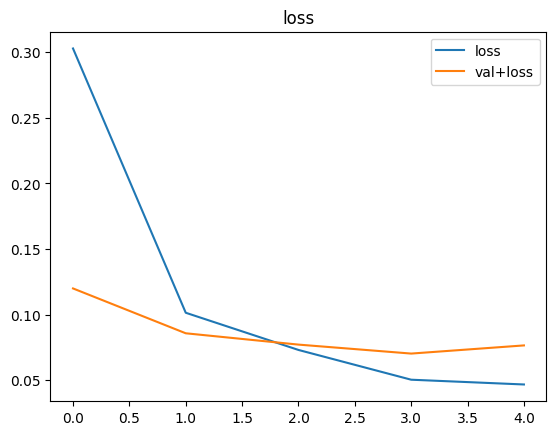

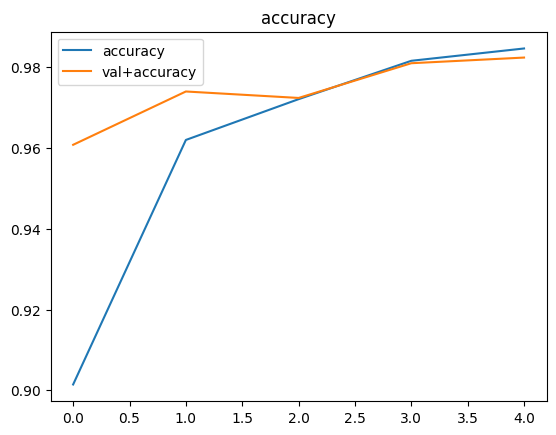

In [42]:
# plot the metrics

plot_history(history)

### Model #4

In [48]:
# define the transfer model

def build_transfer_model4():
  model = Sequential()
  model.add(Input(shape=INPUT_SHAPE))
  model.add(Lambda(preprocessing))
  model.add(BatchNormalization(name='normalizer'))
  model.add(pretrained)
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [49]:
# create the model

transfer_model4 = build_transfer_model4()
transfer_model4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 normalizer (BatchNormalizat  (None, 224, 224, 3)      12        
 ion)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_14 (Dense)            (None, 64)                6422592   
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                      

In [50]:
# fit the model

history_transfer_model4 = transfer_model4.fit(train_ds,
                                              validation_data=val_ds,
                                              epochs=5,
                                              callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
625/625 [==============================] - 553s 881ms/step - loss: 0.3848 - accuracy: 0.9274 - val_loss: 0.1022 - val_accuracy: 0.9668
Epoch 2/5
625/625 [==============================] - 505s 808ms/step - loss: 0.0962 - accuracy: 0.9703 - val_loss: 0.0869 - val_accuracy: 0.9768
Epoch 3/5
625/625 [==============================] - 502s 803ms/step - loss: 0.0601 - accuracy: 0.9791 - val_loss: 0.0873 - val_accuracy: 0.9780
Epoch 4/5
625/625 [==============================] - 498s 796ms/step - loss: 0.0432 - accuracy: 0.9844 - val_loss: 0.0807 - val_accuracy: 0.9808
Epoch 5/5
625/625 [==============================] - 514s 823ms/step - loss: 0.0323 - accuracy: 0.9880 - val_loss: 0.0880 - val_accuracy: 0.9812


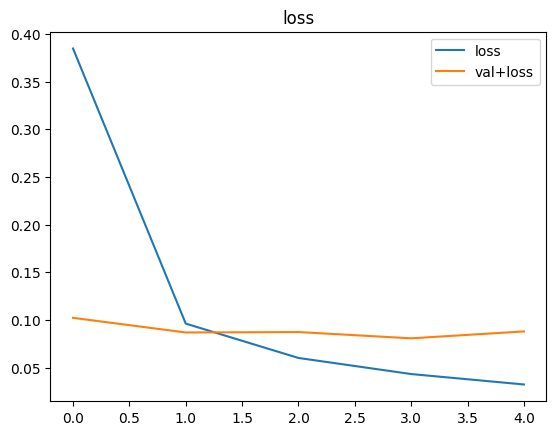

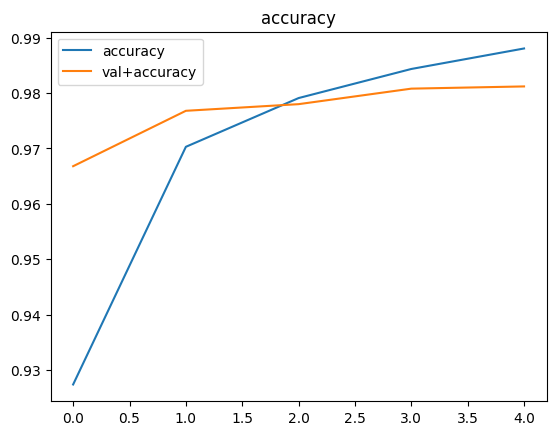

In [52]:
# plot the metrics

plot_history(history_transfer_model4)

- the variance increased, and val_accuracy is also lower, so the previous model performed better